In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#Initiation

In [5]:
from pathlib import Path

import seaborn as sns
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", 100)

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
RANDOM_SEED = 8    # Set a random seed for reproducibility!


from sklearn.preprocessing import OneHotEncoder
from xgboost.sklearn import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.ensemble import StackingClassifier

from sklearn.preprocessing import FunctionTransformer

from numpy import nan
import copy

In [3]:
!pip install catboost

     ---------------------------------------- 73.9/73.9 MB 2.1 MB/s eta 0:00:00
     ---------------------------------------- 15.3/15.3 MB 1.5 MB/s eta 0:00:00
     ---------------------------------------- 47.0/47.0 kB 2.3 MB/s eta 0:00:00


In [20]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [24]:
!python -m pip install sklearn

In [23]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Paths

In [29]:
features_df = pd.read_csv(
   "./Datasets/training_set_features.csv", 
    index_col="respondent_id"
)
labels_df = pd.read_csv(
    "./Datasets/training_set_labels.csv", 
    index_col="respondent_id"
)

In [30]:
test_features_df = pd.read_csv(
    "./Datasets/test_set_features.csv", 
    index_col="respondent_id"
)

In [31]:
submission_df = pd.read_csv(
    "./Datasets/submission_format.csv", 
    index_col="respondent_id"
)

In [32]:
features_df.duplicated().sum()

0

# Describe dataset

In [ ]:
features_df.describe()

In [ ]:
features_df.head()

In [ ]:
labels_df.head()

In [ ]:
#features_df['income_poverty'].isna().sum()

In [ ]:
numeric_cols = features_df.columns[features_df.dtypes != 'object'].values
numeric_cols

In [ ]:
non_numeric_cols = features_df.columns[features_df.dtypes == 'object'].values
non_numeric_cols

array(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status',
       'hhs_geo_region', 'census_msa', 'employment_industry',
       'employment_occupation'], dtype=object)

In [ ]:
for col in features_df.columns.values:
  print(col,'-',features_df[col].isna().sum()/len(features_df[col]))

h1n1_concern - 0.003444789755494814
h1n1_knowledge - 0.00434343056127607
behavioral_antiviral_meds - 0.002658479050436215
behavioral_avoidance - 0.007788220316770884
behavioral_face_mask - 0.0007114239712434942
behavioral_wash_hands - 0.0015726214101171978
behavioral_large_gatherings - 0.0032575729209570526
behavioral_outside_home - 0.0030703560864192908
behavioral_touch_face - 0.004792750964166698
doctor_recc_h1n1 - 0.08087767252031303
doctor_recc_seasonal - 0.08087767252031303
chronic_med_condition - 0.03635750926723331
child_under_6_months - 0.03070356086419291
health_worker - 0.03010446699367207
health_insurance - 0.45957988542329725
opinion_h1n1_vacc_effective - 0.01464035646085296
opinion_h1n1_risk - 0.014528026360130303
opinion_h1n1_sick_from_vacc - 0.01479012992848317
opinion_seas_vacc_effective - 0.017298835511289176
opinion_seas_risk - 0.019245890590481898
opinion_seas_sick_from_vacc - 0.0201070880293556
age_group - 0.0
education - 0.05268281723892612
race - 0.0
sex - 0.0
inc

<ipython-input-56-3283691251ba>:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(features_df.corr(), dtype=np.bool)


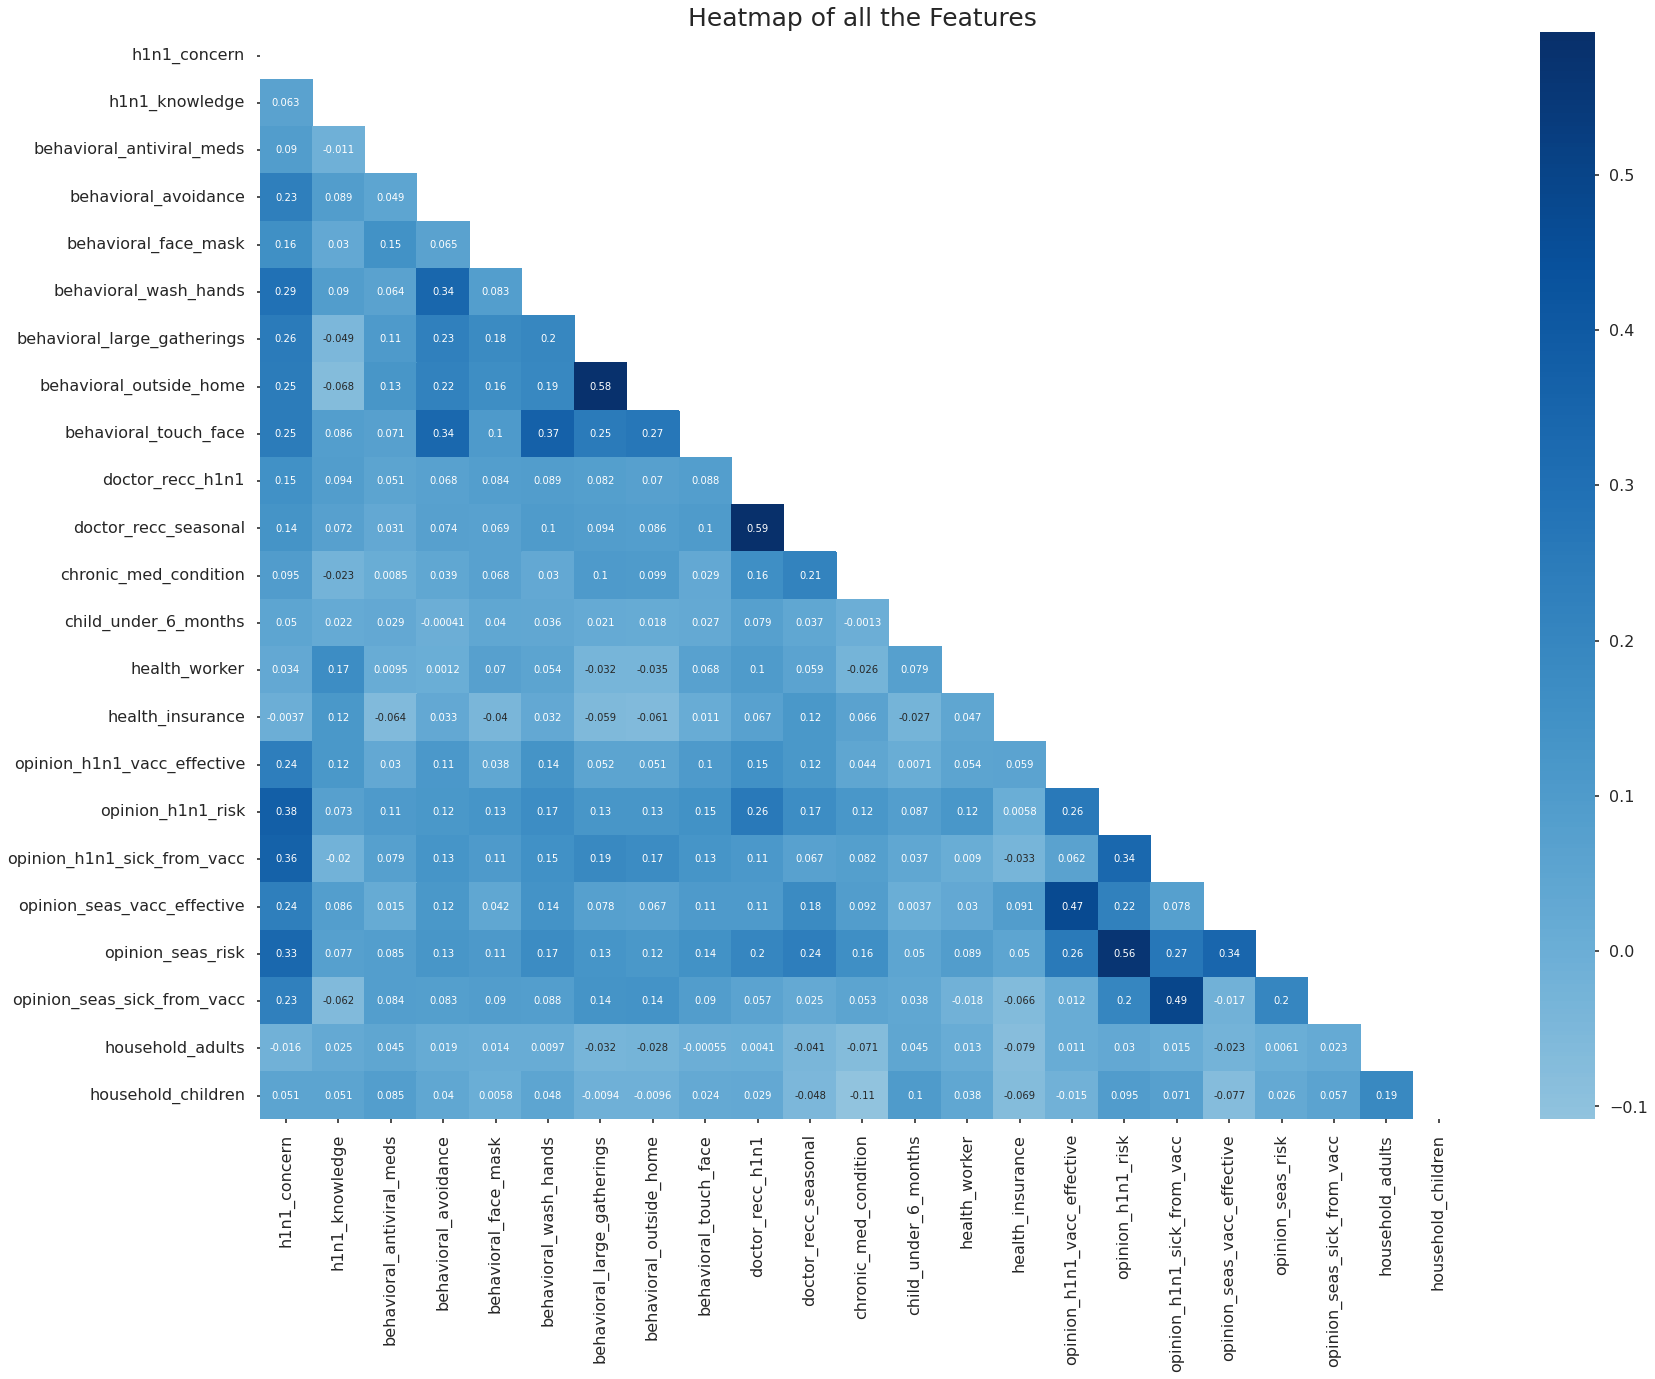

In [56]:
import matplotlib.style as style
import seaborn as sns
style.use('seaborn-poster')
sns.set_style('ticks')
plt.subplots(figsize = (27,20))
## Plotting heatmap. 

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(features_df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sns.heatmap(features_df.corr(), cmap=plt.get_cmap('Blues'), annot=True, mask=mask, center = 0, );
## Give title. 
plt.title("Heatmap of all the Features", fontsize = 25);

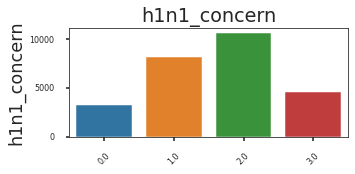

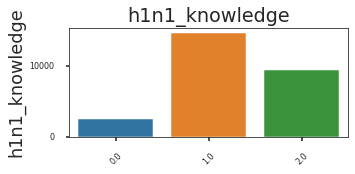

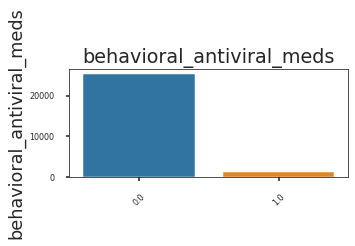

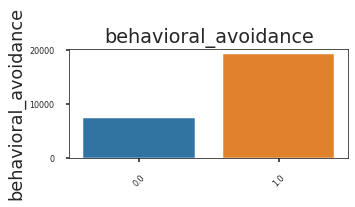

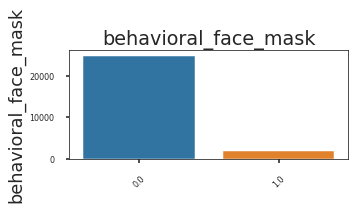

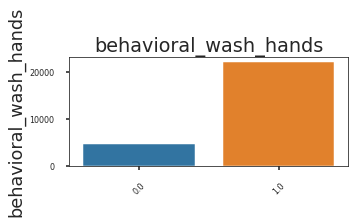

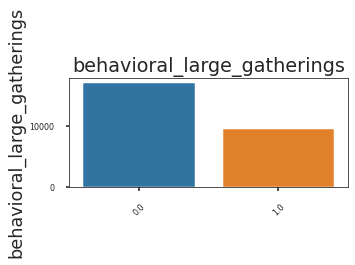

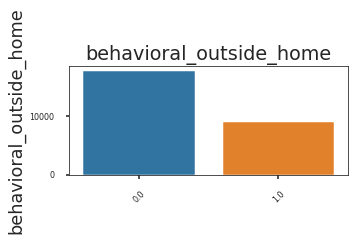

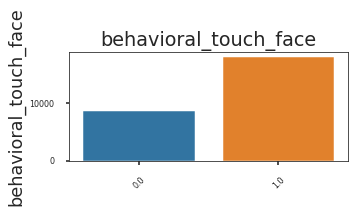

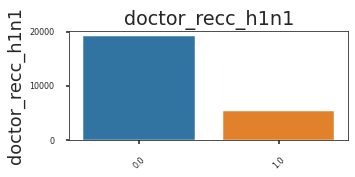

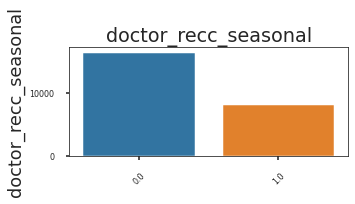

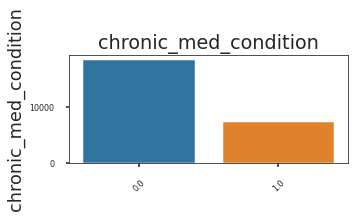

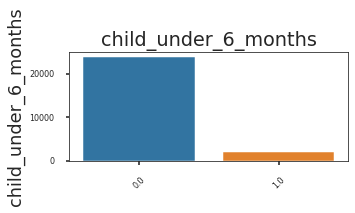

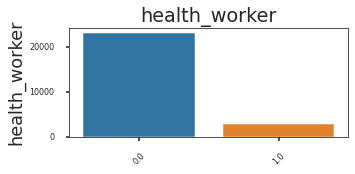

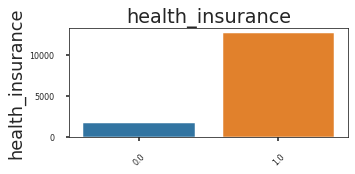

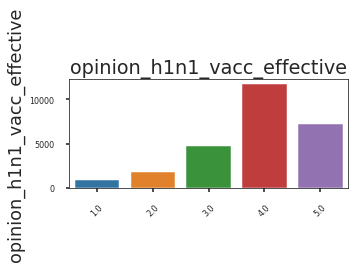

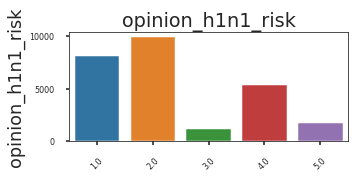

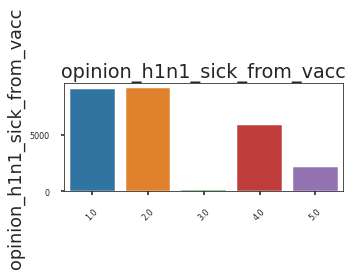

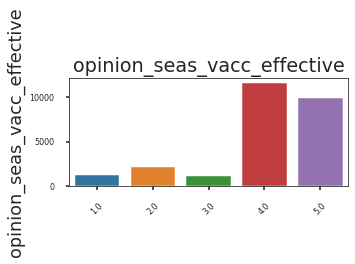

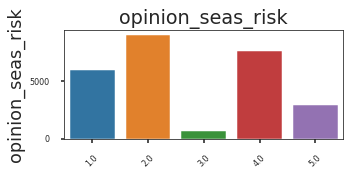

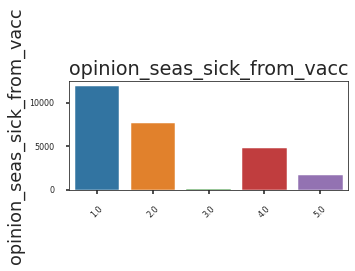

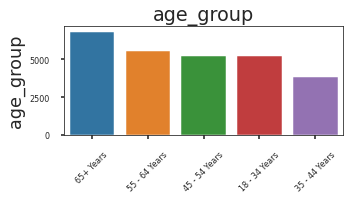

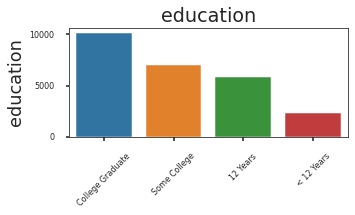

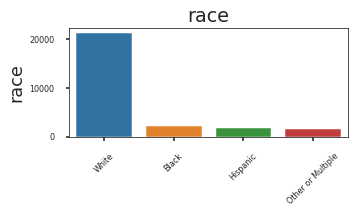

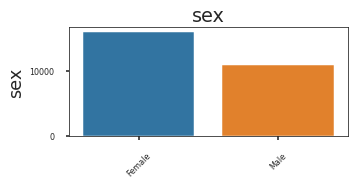

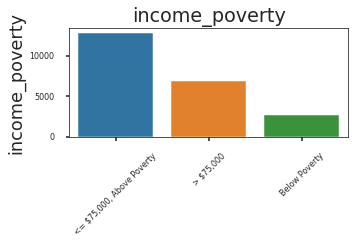

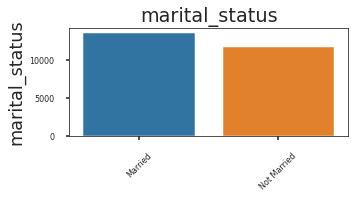

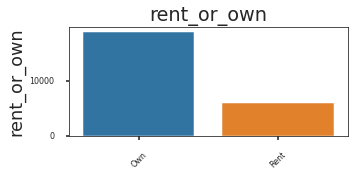

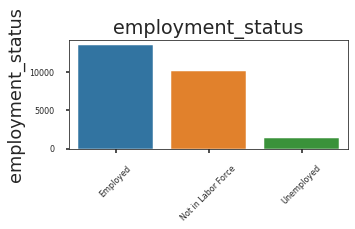

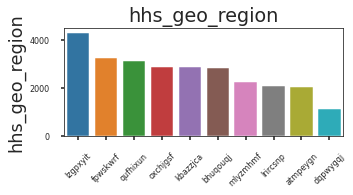

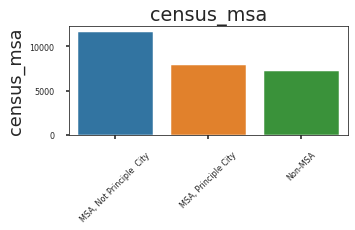

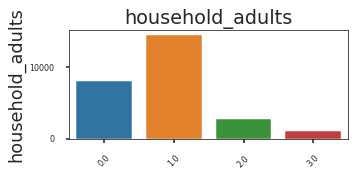

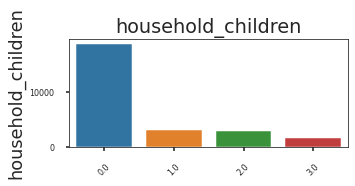

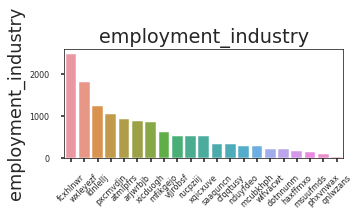

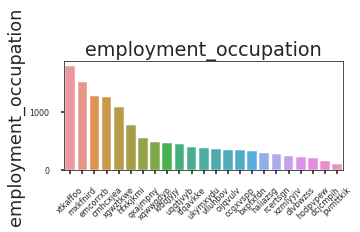

In [91]:
for i in features_df.columns.values:
  ax = sns.barplot(x=features_df[i].value_counts().index, y=features_df[i].value_counts())
  plt.rcParams['figure.figsize'] = (5, 2)  
  plt.xticks(fontsize=8,rotation=45)
  plt.yticks(fontsize=8)
  plt.title(i)
  plt.show()
  plt.close()



In [57]:
labels_df.value_counts()

h1n1_vaccine  seasonal_vaccine
0             0                   13295
              1                    7738
1             1                    4697
              0                     977
dtype: int64

# Preprocessing

In [33]:
numeric_cols = features_df.columns[features_df.dtypes != "object"].values
non_numeric_cols = features_df.columns[features_df.dtypes == 'object'].values

In [34]:
# create age groups numeric values

seperate_processing_cols = ["age_group", "income_poverty","census_msa", 
                            "race", "sex","education","marital_status",
                            "rent_or_own","employment_status"
                            ]
#seperate_processing_cols = []

census_msa_map = {
    'Non-MSA':1,
    'MSA, Not Principle  City':2,
    'MSA, Principle City':3
}

sex_map = {
    'Female':1, 
    'Male':2
}

rent_or_own_map = {
    'Own' :1, 
    'Rent': 2
}

marital_status_map = {
    'Not Married':1, 
    'Married':2
}

employment_status_map = {
    'Not in Labor Force' :1,
    'Unemployed' : 2,
    'Employed' : 3
}

race_map = { 
    'Hispanic':1,
    'Black':2, 
    'White' :3, 
    'Other or Multiple':4
}

education_map = {
    '< 12 Years':1, 
    '12 Years' : 2,  
    'Some College':3,
    'College Graduate':4,
}

age_mean_map = {'18 - 34 Years': 26,
                '35 - 44 Years': 40,
                '45 - 54 Years': 50,
                '55 - 64 Years': 60,
                '65+ Years': 70, 
                }

income_map = {'Below Poverty': 1,
              '<= $75,000, Above Poverty': 2,
              '> $75,000':3
             }


full_map = {"age_group":age_mean_map,
            "income_poverty":income_map,
            "census_msa": census_msa_map,
            "race": race_map,
            "sex": sex_map,
            "education":education_map,
            "marital_status" : marital_status_map,
            "rent_or_own":rent_or_own_map,
            "employment_status": employment_status_map,
            
            }

def map_to_numeric(x, mapping):
    if mapping.get(x) == None:
        return nan
    else:
        return mapping.get(x)

def convert(df):
    new_df = copy.deepcopy(df)
    for col in seperate_processing_cols:
        new_df[col] = df[col].apply(lambda x: map_to_numeric(x, full_map.get(col))) 
    return new_df

numeric_to_cat_transofrmer = FunctionTransformer(convert)   



In [35]:
# chain preprocessing into a Pipeline object
# each step is a tuple of (name you chose, sklearn transformer)
high_missing_cols = [ ]

non_numeric_cols = [x for x in non_numeric_cols if (x not in high_missing_cols and x not in seperate_processing_cols )]
numeric_cols = [x for x in numeric_cols if (x not in high_missing_cols and x not in seperate_processing_cols )]

# chain preprocessing into a Pipeline object
# each step is a tuple of (name you chose, sklearn transformer)
numeric_to_cat_preprocessing_steps = Pipeline([
    ('convert_to_cat', numeric_to_cat_transofrmer),
    #('simple_imputer', SimpleImputer(strategy='constant', fill_value=-1)),
    ('imputer', SimpleImputer(strategy='mean')),
    ('standard_scaler', StandardScaler()),
    ])

numeric_preprocessing_steps = Pipeline(steps=[
    ('standard_scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean'))
    #('simple_imputer', SimpleImputer(strategy='constant', fill_value=-1))
    ])
non_numeric_preprocessing_steps = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    # ('imputer', SimpleImputer(strategy='constant')),
    # ('imputer', SimpleImputer(strategy='most_frequent')),
    # ('onehot', OrdinalEncoder())
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
# create the preprocessor stage of final pipeline
# each entry in the transformer list is a tuple of
# (name you choose, sklearn transformer, list of columns)
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, numeric_cols),
        ("non_numeric",non_numeric_preprocessing_steps,non_numeric_cols),
        ("numeric_to_cat", numeric_to_cat_preprocessing_steps, seperate_processing_cols)
    ],
    remainder = "drop"
)

In [36]:
est_mlp = MLPClassifier(hidden_layer_sizes=(450,350,250), learning_rate='invscaling', learning_rate_init=0.0001,
                          power_t=0.5, max_iter=1500, shuffle=True, tol=0.0001, 
                          early_stopping=True, validation_fraction=0.1, n_iter_no_change=10, max_fun=15000,
                         random_state=RANDOM_SEED)
est_xgb = XGBClassifier(learning_rate =0.02, n_estimators=900, max_depth=6, min_child_weight=2, gamma=0.2,
                             subsample=0.8,colsample_bytree=0.4,reg_alpha=0.1,objective= 'binary:logistic',nthread=4,
                              scale_pos_weight=1 ,reg_lambda = 10 , random_state = 42, class_weight="balanced")
est_gb = GradientBoostingClassifier(random_state=8, n_estimators=800, max_depth=6)
est_rn = RandomForestClassifier(max_depth= 6, bootstrap=True, n_estimators=750)
est_svc = SVC()
est_nb = GaussianNB()
est_kn = KNeighborsClassifier()
est_lgbm = LGBMClassifier()
est_cbc = CatBoostClassifier(iterations=900, learning_rate=0.05,max_depth=6,subsample=0.6)



estimators_stacked = [
            ('xbg', est_xgb),
              ('mlp', est_mlp), 
             ('cbc', est_cbc)
              # ('nb', est_nb),
                 #('gb', est_gb)
              # ('rn', est_rn),
            #  ('lgbm', est_lgbm)
              #('kn', est_kn)
             ]

stacked_estimator =  StackingClassifier(estimators=estimators_stacked,
                                    final_estimator=LogisticRegression(class_weight="balanced"),
                                    stack_method='predict_proba'
                                  )

In [37]:
estimators = MultiOutputClassifier(
    estimator = stacked_estimator
)

In [38]:
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimators),
])

# Check Manual

In [39]:
X_train, X_eval, y_train, y_eval = train_test_split(  
    features_df,
    labels_df,
    test_size=0.2,
    shuffle=True,
    stratify=labels_df,
    random_state=RANDOM_SEED
)

In [40]:
%%time

#Train model
full_pipeline.fit(X_train, y_train)

# Predict on evaluation set
# This competition wants probabilities, not labels
preds = full_pipeline.predict_proba(X_eval)
preds

[02:13:45] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

0:	learn: 0.6525023	total: 172ms	remaining: 2m 34s
1:	learn: 0.6186271	total: 182ms	remaining: 1m 21s
2:	learn: 0.5880891	total: 192ms	remaining: 57.3s
3:	learn: 0.5620359	total: 200ms	remaining: 44.7s
4:	learn: 0.5390500	total: 209ms	remaining: 37.4s
5:	learn: 0.5186165	total: 217ms	remaining: 32.4s
6:	learn: 0.5012140	total: 227ms	remaining: 29s
7:	learn: 0.4875575	total: 234ms	remaining: 26.1s
8:	learn: 0.4727332	total: 243ms	remaining: 24.1s
9:	learn: 0.4600555	total: 251ms	remaining: 22.3s
10:	learn: 0.4502618	total: 260ms	remaining: 21.1s
11:	learn: 0.4408452	total: 269ms	remaining: 19.9s
12:	learn: 0.4330214	total: 277ms	remaining: 18.9s
13:	learn: 0.4250979	total: 286ms	remaining: 18.1s
14:	learn: 0.4186648	total: 294ms	remaining: 17.4s
15:	learn: 0.4125982	total: 303ms	remaining

In [ ]:
y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": preds[0][:, 1],
        "seasonal_vaccine" :  preds[1][:, 1]
    },
    index = y_eval.index
)
print("y_preds.shape:", y_preds.shape)
y_preds.head()

y_preds.shape: (5342, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
7498,0.879576,0.141784
19431,0.224062,0.893760
11280,0.735001,0.273257
1929,0.135839,0.097219
20053,0.335056,0.657265


In [ ]:
roc_auc_score(y_eval, y_preds)

0.8718540024306144

In [ ]:
roc_auc_score(y_eval["seasonal_vaccine"], y_preds["seasonal_vaccine"])

0.8692093457143695

In [ ]:
roc_auc_score(y_eval["h1n1_vaccine"], y_preds["h1n1_vaccine"])

0.8744986591468593

# Results

In [ ]:
%%time 

full_pipeline.fit(features_df, labels_df)

None   # So we don't print out the whole pipeline representation

Streaming output truncated to the last 5000 lines.
402:	learn: 0.4119091	total: 4.18s	remaining: 5.15s
403:	learn: 0.4117980	total: 4.18s	remaining: 5.14s
404:	learn: 0.4116580	total: 4.19s	remaining: 5.13s
405:	learn: 0.4115401	total: 4.2s	remaining: 5.11s
406:	learn: 0.4114457	total: 4.21s	remaining: 5.1s
407:	learn: 0.4112863	total: 4.22s	remaining: 5.09s
408:	learn: 0.4111688	total: 4.23s	remaining: 5.08s
409:	learn: 0.4110648	total: 4.24s	remaining: 5.07s
410:	learn: 0.4109154	total: 4.25s	remaining: 5.06s
411:	learn: 0.4108041	total: 4.26s	remaining: 5.04s
412:	learn: 0.4106799	total: 4.27s	remaining: 5.03s
413:	learn: 0.4105265	total: 4.28s	remaining: 5.02s
414:	learn: 0.4104097	total: 4.29s	remaining: 5.01s
415:	learn: 0.4103306	total: 4.29s	remaining: 5s
416:	learn: 0.4101712	total: 4.3s	remaining: 4.99s
417:	learn: 0.4100853	total: 4.33s	remaining: 4.99s
418:	learn: 0.4099878	total: 4.34s	remaining: 4.98s
419:	learn: 0.4098562	total: 4.35s	remaining: 4.97s
420:	learn: 0.40972

In [ ]:
test_probas = full_pipeline.predict_proba(test_features_df)

In [ ]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_features_df.index.values, 
                              submission_df.index.values)

# Save predictions to submission data frame
submission_df["h1n1_vaccine"] = test_probas[0][:, 1]
submission_df["seasonal_vaccine"] = test_probas[1][:, 1]

submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.232663,0.203828
26708,0.177813,0.086643
26709,0.386929,0.819953
26710,0.931029,0.896395
26711,0.504468,0.431390


In [45]:
submission_df.to_csv('submission.csv', index=True)

In [46]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
!head submission.csv

respondent_id,h1n1_vaccine,seasonal_vaccine
26707,0.2326634869094106,0.20382787848683762
26708,0.17781337488880672,0.08664328590574837
26709,0.3869292887420079,0.8199530425019169
26710,0.9310285452441744,0.8963950822591069
26711,0.504467800939632,0.43138954523090484
26712,0.975783233565414,0.9359850653645065
26713,0.4397472296106728,0.6869471072514393
26714,0.34431295865065925,0.14321299518898886
26715,0.16752919859502907,0.10994199148196669
